# SVM Radial Kernel Prediction Application for Life Expectancy
The Purpose of the below code is to predict life expectancy using a radial kernel support vector machine. 

In [1]:
# Show more columns and load necessary packages.
library(ggplot2)
library(e1071)
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)

# Load in the libraries and dataset.
df = read.csv('le_svm.csv')
df = na.omit(df)
df = df[complete.cases(df),]
sum(is.na(df))
dim(df)
head(df)

[1] 0

[1] 13132    54

,hhidpn,wave,mstat,cendiv,gender,rahispan,raracem,iwbeg,dage_m,dage_y,raedyrs,rarelig,ravetrn,agey_m,shlt,shltc,depres,effort,sleepr,cesd,bmi,smokev,smoken,drinkn,hibp,diab,cancr,lung,heart,strok,psych,arthr,conde,cogtot,slfmem,pstmem,spcfac,hsptim,puff,puffpos,timwlk,hatotb,iearn,isret,covs,hiltc,lbrf,logiearn,logisret,loghspti,loghatotb,id,nt,n2
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,3010,3,1.married,9.pacific,1.male,0.not hispanic,1.white/caucasian,13345,931,77,12,1.protestant,0.no,60,3.good,-1,1.yes,1.yes,1.yes,3,28.0,0.no,0.no,1,0.no,0.no,0.no,0.no,1.yes,0.no,0.no,0.no,1,35,4.fair,2.same,0.no,0,,,,490500,4000,0,1.yes,1.yes,4.partly retired,8.294049,0.000000,0,13.10318,2,123702,7
2,3010,6,1.married,9.pacific,1.male,0.not hispanic,1.white/caucasian,15445,931,77,12,1.protestant,0.no,66,3.good,-1,0.no,0.no,0.no,1,28.3,0.no,0.no,0,0.no,0.no,0.no,0.no,1.yes,0.no,0.no,0.no,1,31,3.good,2.same,0.no,0,,,,704000,10000,13728,0.no,1.yes,4.partly retired,9.210340,9.527193,0,13.46453,3,123702,7
3,3010,7,1.married,9.pacific,1.male,0.not hispanic,1.white/caucasian,16267,931,77,12,1.protestant,0.no,68,3.good,0,0.no,0.no,0.no,0,26.6,0.no,0.no,0,0.no,0.no,0.no,0.no,1.yes,0.no,0.no,0.no,1,18,3.good,2.same,0.no,0,,,,756000,6000,15600,0.no,1.yes,4.partly retired,8.699514,9.655026,0,13.53580,4,123702,7
4,3010,8,1.married,9.pacific,1.male,0.not hispanic,1.white/caucasian,16875,931,77,12,1.protestant,0.no,70,3.good,0,0.no,0.no,0.no,0,27.1,0.no,0.no,0,0.no,0.no,0.no,0.no,1.yes,0.no,0.no,0.no,1,20,4.fair,2.same,0.no,0,490,1.standing,2.78,914000,0,14040,0.no,1.yes,5.retired,0.000000,9.549665,0,13.72559,5,123702,7
5,3010,9,1.married,9.pacific,1.male,0.not hispanic,1.white/caucasian,17577,931,77,12,1.protestant,0.no,72,3.good,0,0.no,0.no,0.no,0,24.7,0.no,0.no,1,0.no,0.no,0.no,0.no,1.yes,0.no,0.no,0.no,1,26,3.good,2.same,0.no,1,.a,.a=r not asked phys meas this wave,.a,1156000,0,15600,0.no,1.yes,5.retired,0.000000,9.655026,0,13.96048,6,123702,7
6,3010,10,1.married,9.pacific,1.male,0.not hispanic,1.white/caucasian,18520,931,77,12,1.protestant,0.no,74,3.good,0,0.no,0.no,0.no,0,24.0,0.no,0.no,0,0.no,0.no,0.no,0.no,1.yes,0.no,0.no,0.no,1,17,4.fair,3.worse,0.no,0,330,1.standing,3.0999999,1240000,0,16644,0.no,1.yes,5.retired,0.000000,9.719805,0,14.03062,7,123702,7


In [2]:
# Drop the same variable, just in month format.
df = subset(df, select = -c(dage_m, id, nt, n2, cesd, timwlk, puff, puffpos, iwbeg, hhidpn))
dim(df)

[1] 13132    44

In [3]:
# Specify data as numeric or factor.
df = na.omit(df)
names_factor = c('gender', 'raracem', 'rahispan', 'mstat', 'shlt', 
                 'depres', 'cendiv' , 'effort', 
                 'sleepr', 'arthr','heart', 'strok', 'psych', 'cancr', 'wave',
                  'slfmem', 'covs',
                  'lbrf', 'smokev',  'hiltc',
                  'spcfac', 'rarelig','ravetrn')
df[,names_factor] = lapply(df[,names_factor], factor)
names_numeric = c('iearn', 'logiearn', 'bmi', 'cogtot','drinkn',
                   'dage_y','conde', 'raedyrs',
                  'logisret', 'loghatotb','loghspti')
df[,names_numeric] = lapply(df[,names_numeric], as.numeric)
dim(df)

Warning message in lapply(df[, names_numeric], as.numeric):
“NAs introduced by coercion”
Warning message in lapply(df[, names_numeric], as.numeric):
“NAs introduced by coercion”


[1] 13132    44

In [4]:
#Create tests and training sets.
n = dim(df)[1]
training_ratio = .8
train_size = sort(sample(1:n, training_ratio*n))
train = na.omit(df[train_size,])
test = na.omit(df[-train_size,])

# Create models to be used in kernel.
train_mat = model.matrix(covs ~ dage_y +cogtot + gender+raracem+rahispan+mstat+
                         shlt+depres+cendiv+effort+sleepr+arthr+heart+strok+
                         psych+cancr+wave+slfmem+covs+lbrf+smokev+
                         hiltc+spcfac+rarelig+ravetrn+iearn+logiearn+bmi+
                         cogtot+drinkn+conde+raedyrs+
                         logisret+loghatotb+loghspti, train)
test_mat = model.matrix(covs ~ dage_y + cogtot + gender+raracem+rahispan+mstat+
                         shlt+depres+cendiv+effort+sleepr+arthr+heart+strok+
                         psych+cancr+wave+slfmem+covs+lbrf+smokev+
                         hiltc+spcfac+rarelig+ravetrn+iearn+logiearn+bmi+
                         cogtot+drinkn+conde+raedyrs+
                         logisret+loghatotb+loghspti, test)

Warning message in model.matrix.default(covs ~ dage_y + cogtot + gender + raracem + :
“the response appeared on the right-hand side and was dropped”
Warning message in model.matrix.default(covs ~ dage_y + cogtot + gender + raracem + :
“problem with term 19 in model.matrix: no columns are assigned”
Warning message in model.matrix.default(covs ~ dage_y + cogtot + gender + raracem + :
“the response appeared on the right-hand side and was dropped”
Warning message in model.matrix.default(covs ~ dage_y + cogtot + gender + raracem + :
“problem with term 19 in model.matrix: no columns are assigned”


In [5]:
# Test to make sure dimensions are square.
dim(train_mat)
dim(test_mat)
dim(train)
dim(test)
sum(is.na(train_mat))
sum(is.na(test_mat))
#typeof(train_mat[1])
#train_mat

[1] 4722   86

[1] 1207   86

[1] 4722   44

[1] 1207   44

[1] 0

[1] 0

In [7]:
# Scale featrues.
#train_mat = scale(as.matrix(train_mat))
#test_mat = scale(as.matrix(test_mat))

# Time for SVM

In [8]:
library(e1071)

# Run SVM with Radial Kernel.
svm_m0 = svm(formula = dage_y ~ ., 
             data = train,
             kernel = 'radial',
             type = 'eps-regression',
             scale = TRUE
            )

# Make predictions and calculate Root Mean-Squared Error.
pred = predict(svm_m0, test)
rmse = sqrt(mean((test$dage_y - pred)^2))
rmse

[1] 2.237312

In [10]:
test['prediction'] = as.data.frame(pred)

### Graph Predictions compared to observations to visualize model accuracy.
To do this, the data is ordered in observations from youngest age at death to the oldest. We then plot observations by age at death and plot observations by predicted life expectancy. 

Warning message:
“Removed 8 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 8 rows containing non-finite values (stat_density2d_filled).”
Warning message:
“Removed 3 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 3 rows containing non-finite values (stat_density2d_filled).”
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”


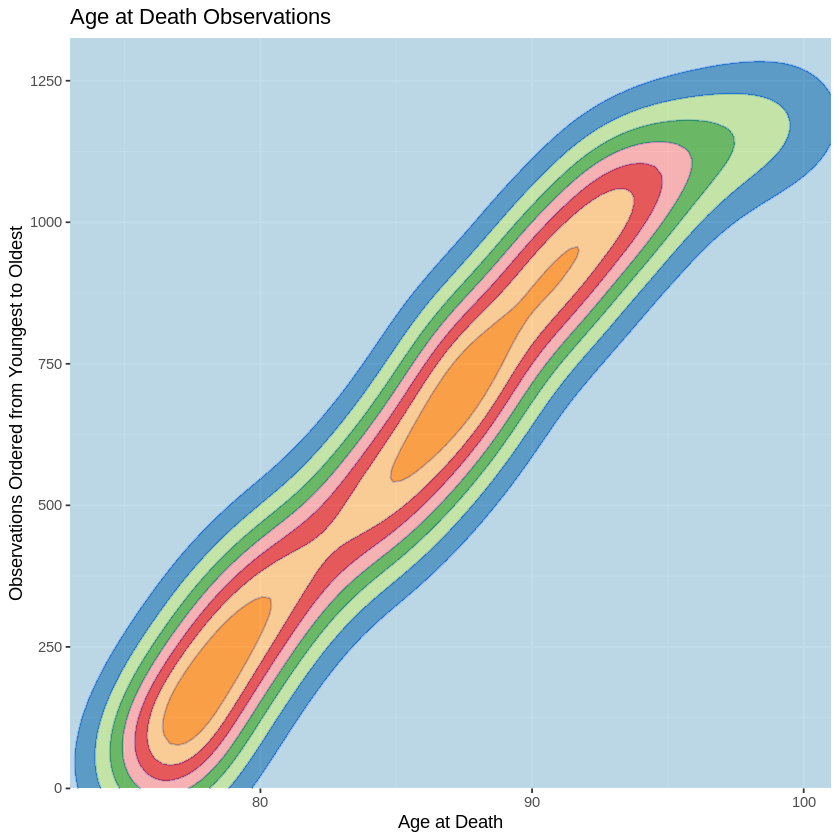

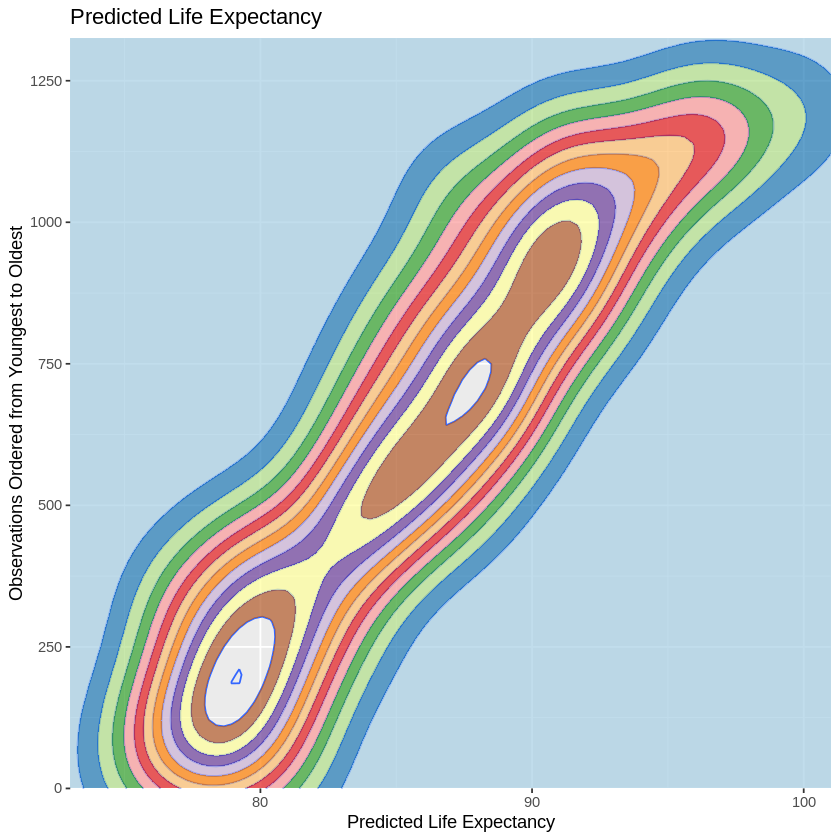

In [13]:
library(cowplot)
test$n = 1:nrow(test)
test1 = test[order(test$dage_y),]
#test1= test[sample(1:nrow(test)), ]

p1 = ggplot(test, aes(x = test1$dage_y, y = n)) +
            ggtitle("Age at Death Observations") +
            xlab("Age at Death") + ylab("Observations Ordered from Youngest to Oldest")  +
            geom_density_2d(show.legend=FALSE)  + geom_density_2d_filled(alpha = .7,show.legend=FALSE)+
            scale_x_continuous(expand = c(0, 0), limits = c(73, 101)) + 
            scale_y_continuous(expand = c(0, 0), limits = c(0, 1325)) +
            scale_fill_brewer(palette = 'Paired')
p2 = ggplot(test, aes(x = test1$prediction, y = n))+
            ggtitle("Predicted Life Expectancy") +
            xlab("Predicted Life Expectancy") + ylab("Observations Ordered from Youngest to Oldest")  +
            geom_density_2d()+ 
            geom_density_2d_filled(alpha = 0.7,show.legend=FALSE) +
            scale_x_continuous(expand = c(0, 0), limits = c(73, 101)) + 
            scale_y_continuous(expand = c(0, 0), limits = c(0, 1325)) +
            scale_fill_brewer(palette = 'Paired')

p1
p2

Warning message:
“Removed 12 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 12 rows containing non-finite values (stat_density2d_filled).”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 1 rows containing non-finite values (stat_density2d_filled).”
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


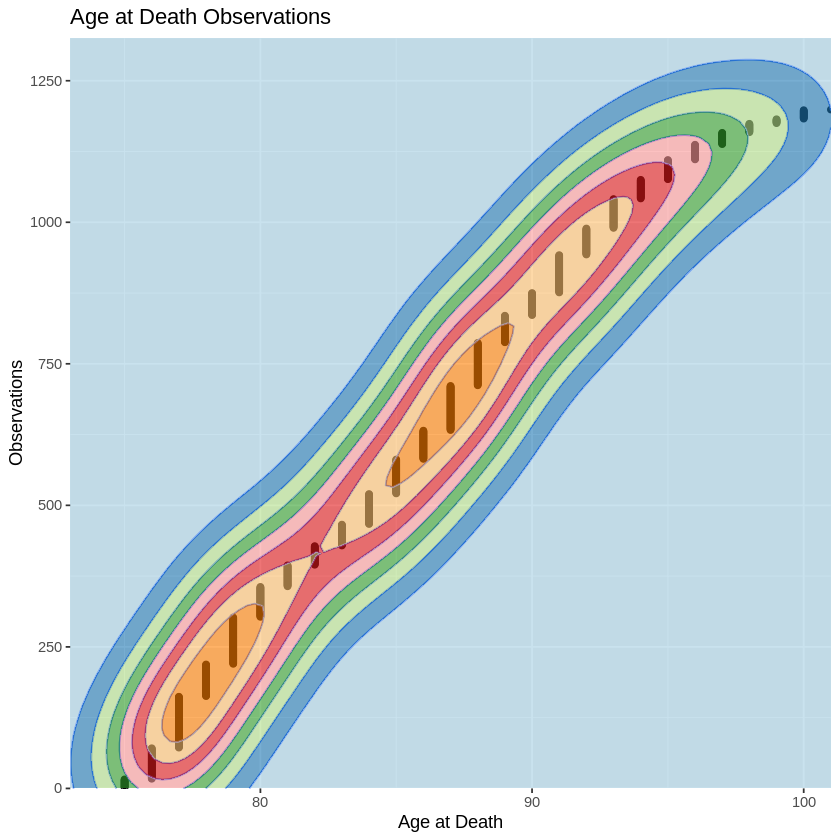

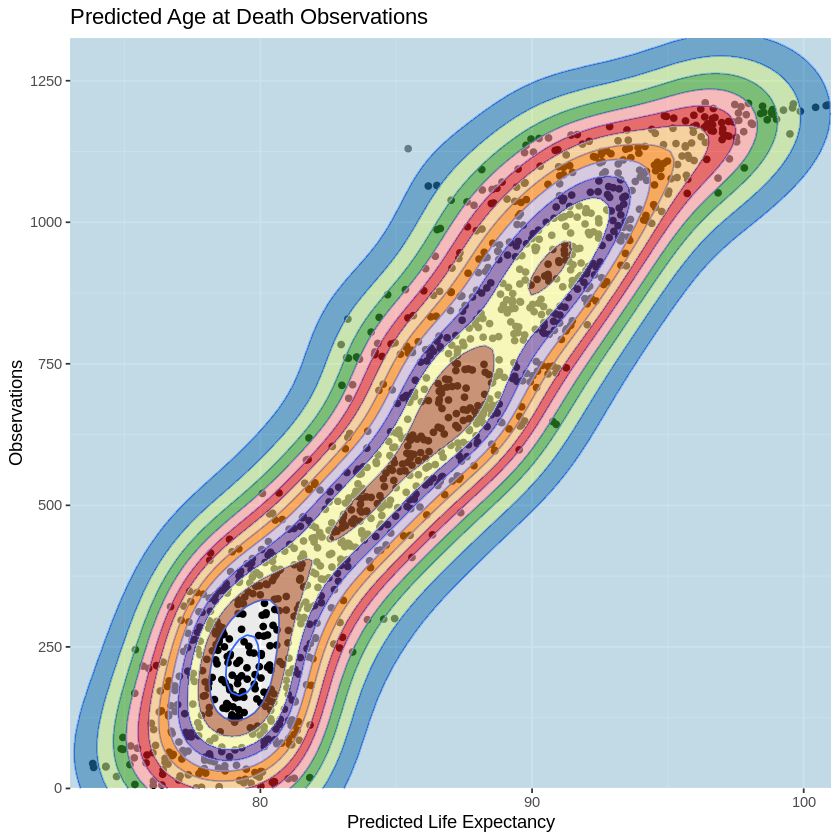

In [13]:
p1 = ggplot(test, aes(x = test1$dage_y, y = n)) +
            geom_point() +
            ggtitle("Age at Death Observations") +
            xlab("Age at Death") + ylab("Observations")  +
            geom_density_2d(show.legend=FALSE)  + 
            geom_density_2d_filled(alpha = .6,show.legend=FALSE)+
            scale_x_continuous(expand = c(0, 0), limits = c(73, 101)) + 
            scale_y_continuous(expand = c(0, 0), limits = c(0, 1325)) +
            scale_fill_brewer(palette = 'Paired')
p2 = ggplot(test, aes(x = test1$prediction, y = n))+
            geom_point() +
            ggtitle("Predicted Age at Death Observations") +
            xlab("Predicted Life Expectancy") + ylab("Observations")  +
            geom_density_2d()+ 
            geom_density_2d_filled(alpha = 0.6,show.legend=FALSE) +
            scale_x_continuous(expand = c(0, 0), limits = c(73, 101)) + 
            scale_y_continuous(expand = c(0, 0), limits = c(0, 1325))  +
            scale_fill_brewer(palette = 'Paired')


p1
p2

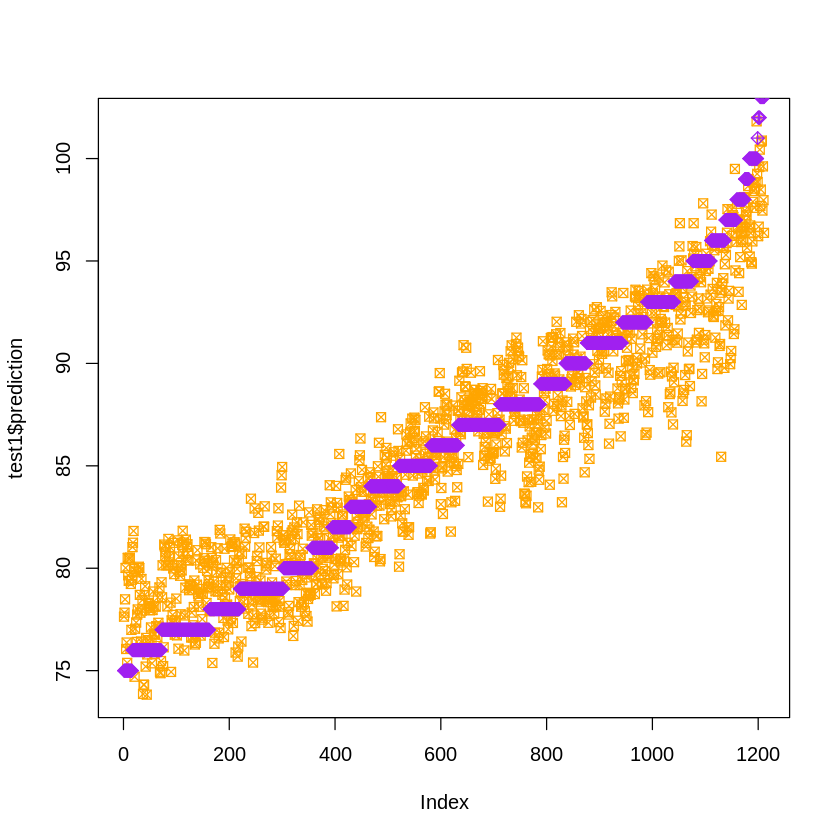

In [17]:
plot(test1$prediction, col = 'orange', pch = 7)
points(test1$dage_y, col = 'purple', pch = 9)

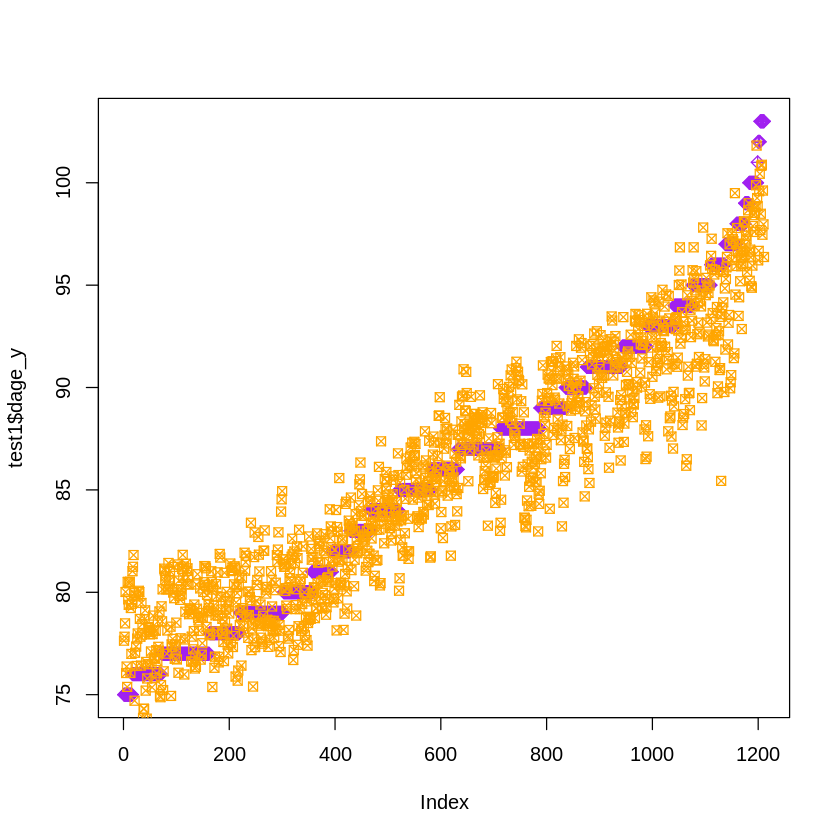

In [23]:
plot(test1$dage_y, col = 'purple', pch = 9)
points(test1$prediction, col = 'orange', pch = 7)

In [76]:
mean(test$dage_y)

[1] 86.12977